In [563]:
from seqdata import getset
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pylab as plt
import numpy
from numpy import argmax, vstack
import random
import torch
from torch import Tensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.nn import Linear,ReLU, LeakyReLU,ELU,Softmax,Module,CrossEntropyLoss
from torch.optim import SGD,Adam
from torch.nn.init import kaiming_uniform_,xavier_uniform_, uniform_, ones_, zeros_, eye_
from torch.nn.parameter import Parameter



In [529]:
def xsample(x0,size):
    res=[]
    while size-len(res)>=len(x0):
        res.extend(x0)
    res.extend(random.sample(x0,size-len(res)))
    return res

def prepare_data(cats, cat_size=1000, batch_size=10):
    X,y=getset(7)
    X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=1234567, shuffle=True)
    
    u,c=numpy.unique(y_train, return_counts=True)
    print(f"Counts for minimal group: {numpy.min(c)}")
    print(f"Counts for maximal group: {numpy.max(c)}")
    
    joined=[(x,lab) for x,lab in zip(X_train,y_train) if lab in cats]
    X_train=[x for x,lab in joined]
    y_train=[lab for x,lab in joined]
    
    
    joined=[(x,lab) for x,lab in zip(X_test,y_test) if lab in cats]
    X_test=[x for x,lab in joined]
    y_test=[lab for x,lab in joined]
    
    
    test=[[numpy.array(x,dtype=numpy.float32),y] for x,y in zip(X_test,numpy.array(y_test,dtype=numpy.int64))]    
    if cat_size>0:
        train=[]    
        #resample X_train and y_train
        random.seed(None) #1234567)
        new_X,new_y=[],[]
        for cat in cats:
            cat_xy=[(x,lab) for x,lab in zip(X_train,y_train) if lab==cat]
            qs=xsample(cat_xy, cat_size)
            #qs=[random.choice(cat_xy) for ii in range(cat_size)]
            qs=[[numpy.array(x,dtype=numpy.float32),numpy.array(lab,dtype=numpy.int64)] for x,lab in qs]
            train.extend(qs)
    else:
        train=[[numpy.array(x, dtype=numpy.float32),y] for x,y in zip(X_train,numpy.array(y_train,dtype=numpy.int64))]
   
    print(f'train data: {len(train)}, test data: {len(test)}, categories: {len(cats)}' )
    train_dl = DataLoader(train, batch_size=batch_size, shuffle=True)
    test_dl = DataLoader(test, batch_size=100000000, shuffle=False)
    return train_dl, test_dl

In [464]:
class MLP(Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        N=161*1
        
        self.hidden1 = Linear(n_inputs, N)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        #uniform_(self.hidden1.weight)
        #ones_(self.hidden1.weight)
        self.act1 = LeakyReLU()

        self.hidden_last = Linear(N, 20)   
        #kaiming_uniform_(self.hidden_last.weight)        
        #xavier_uniform_(self.hidden_last.weight)
        #uniform_(self.hidden_last.weight)
        ones_(self.hidden_last.weight)
        self.act_last = Softmax(dim=1)
    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
        #last
        X = self.hidden_last(X)
        X = self.act_last(X)
        return X

In [598]:
def train_model(train_dl, model, n_epoch=100, lr=0.01):
    # define the optimization
    criterion = CrossEntropyLoss() #weight=whs)
    #optimizer = Adam(model.parameters(),lr=0.01)
    optimizer = SGD(model.parameters(), lr=lr, momentum=0.9)
    # enumerate epochs
    for epoch in range(n_epoch):
        # enumerate mini batches
        losses=[]
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
            losses.append(loss.detach().numpy())
        print(epoch, numpy.mean(losses))
 

In [466]:
# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        # convert to class labels
        yhat = argmax(yhat, axis=1)
        # reshape for stacking
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    plt.hist(predictions, bins=20,alpha=0.2)
    plt.hist(actuals, bins=20,alpha=0.2)
    plt.show()
    n_uniq=numpy.unique(predictions)
    return acc,len(n_uniq)

train data: 1000, test data: 38829, categories: 20
0 2.9388409
1 2.8095176
2 2.710383
3 2.664299
4 2.6467307
5 2.6039634
6 2.552373
7 2.5059083
8 2.484841
9 2.480445
10 2.477542
11 2.4694016
12 2.451606
13 2.4359632
14 2.4320095
15 2.4300077
16 2.4284182
17 2.4202774
18 2.399177
19 2.3703718
20 2.3500004
21 2.3397598
22 2.3326147
23 2.3270278
24 2.319996
25 2.3159351
26 2.3118215
27 2.3091335
28 2.3077106
29 2.3049607
30 2.2985625
31 2.2901244
32 2.2830837
33 2.2781022
34 2.2728903
35 2.2701962
36 2.2682586
37 2.2673619
38 2.2665544
39 2.2654793
40 2.2651212
41 2.264421
42 2.2640738
43 2.2637148
44 2.263258
45 2.2629387
46 2.262681
47 2.2624505
48 2.2621207
49 2.2618504
50 2.2614145
51 2.2611299
52 2.2608447
53 2.2606452
54 2.2604892
55 2.2602885
56 2.2602055
57 2.2600405
58 2.2599466
59 2.2598238
60 2.2596455
61 2.25962
62 2.2594907
63 2.259436
64 2.2593315
65 2.2592564
66 2.2591672
67 2.2590766
68 2.259012
69 2.2589512
70 2.25887
71 2.2588167
72 2.2587457
73 2.2586827
74 2.2586226
75

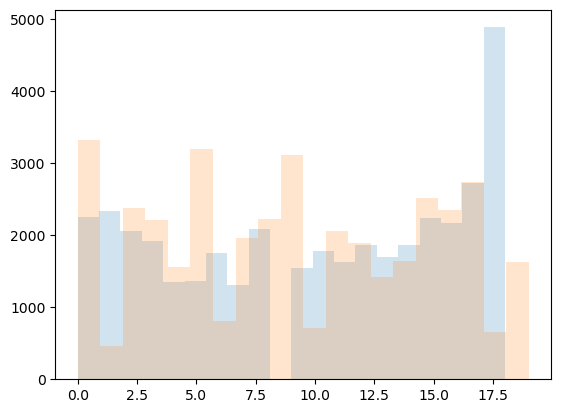

Accuracy: 0.065
0 2.9373827
1 2.804561
2 2.717406
3 2.6649325
4 2.6379943
5 2.6074197
6 2.5549154
7 2.5034907
8 2.4858208
9 2.4804838
10 2.4773517
11 2.4629683
12 2.4419281
13 2.4341938
14 2.4311042
15 2.429349
16 2.4258492
17 2.4118776
18 2.3884177
19 2.3622458
20 2.3453388
21 2.335211
22 2.3272839
23 2.321679
24 2.314895
25 2.3101668
26 2.3077123
27 2.3056736
28 2.3040223
29 2.3006012
30 2.2897568
31 2.2829041
32 2.276027
33 2.2706633
34 2.2685573
35 2.267647
36 2.2661843
37 2.2653847
38 2.264484
39 2.26399
40 2.2633703
41 2.2628868
42 2.2625208
43 2.2621245
44 2.2618473
45 2.2615457
46 2.2613566
47 2.2611372
48 2.260904
49 2.2607558
50 2.2605565
51 2.2603793
52 2.2601976
53 2.2600884
54 2.259923
55 2.259839
56 2.259718
57 2.2596123
58 2.259482
59 2.2593849
60 2.2592993
61 2.2592144
62 2.2591217
63 2.2590506
64 2.2589529
65 2.2588847
66 2.2588246
67 2.2587578
68 2.258684
69 2.2586155
70 2.258558
71 2.258506
72 2.2584472
73 2.2584138
74 2.258356
75 2.2582967
76 2.258253
77 2.2582068
7

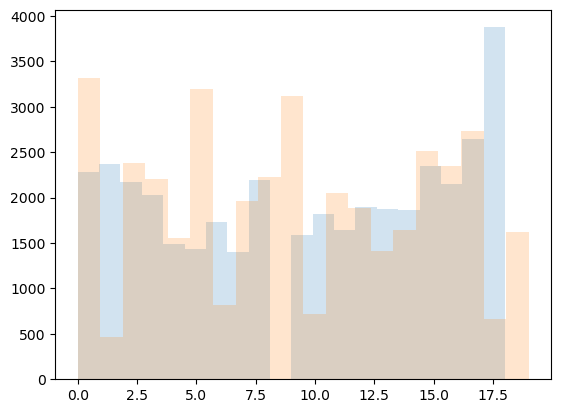

Accuracy: 0.066
0 2.9395885
1 2.8131223
2 2.714515
3 2.659696
4 2.6184757
5 2.5451996
6 2.4985845
7 2.4847898
8 2.479775
9 2.4770248
10 2.459267
11 2.4404588
12 2.4342282
13 2.430986
14 2.4290807
15 2.427818
16 2.4265468
17 2.41368
18 2.3846464
19 2.3662422
20 2.355896
21 2.347902
22 2.337605
23 2.328892
24 2.3172448
25 2.3094215
26 2.2922103
27 2.2823555
28 2.2760801
29 2.2730336
30 2.269721
31 2.268042
32 2.266687
33 2.2659833
34 2.2648711
35 2.2645907
36 2.2637296
37 2.2634177
38 2.2627733
39 2.2625046
40 2.2620602
41 2.2618034
42 2.261521
43 2.261346
44 2.261063
45 2.260857
46 2.260662
47 2.260462
48 2.2602994
49 2.2601316
50 2.259991
51 2.2599006
52 2.2597458
53 2.2596052
54 2.2595317
55 2.2594416
56 2.259313
57 2.2592332
58 2.2591207
59 2.2590408
60 2.2589712
61 2.2588944
62 2.2588184
63 2.2587492
64 2.2586727
65 2.2586067
66 2.2585497
67 2.2584922
68 2.258427
69 2.2583678
70 2.258313
71 2.2582672
72 2.2582195
73 2.258167
74 2.2581227
75 2.2580614
76 2.2580307
77 2.2579772
78 2.2

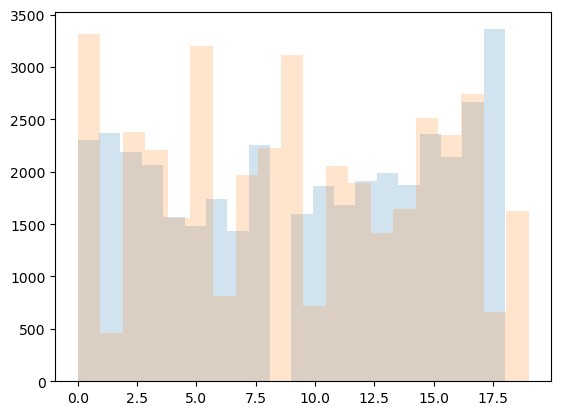

Accuracy: 0.067
0 2.938885
1 2.8040926
2 2.712335
3 2.667684
4 2.6470764
5 2.5988028
6 2.5208848
7 2.4908957
8 2.4824357
9 2.478289
10 2.471715
11 2.4497876
12 2.43689
13 2.432048
14 2.429493
15 2.4277687
16 2.4213564
17 2.406104
18 2.3923109
19 2.3725219
20 2.3537476
21 2.3422117
22 2.3311236
23 2.322011
24 2.3177843
25 2.3114223
26 2.3080096
27 2.3051162
28 2.30338
29 2.2970045
30 2.2857244
31 2.2759092
32 2.271041
33 2.2689512
34 2.2669883
35 2.2657137
36 2.264666
37 2.2640102
38 2.263567
39 2.2628906
40 2.2626908
41 2.262203
42 2.2616854
43 2.261442
44 2.2611883
45 2.2609441
46 2.2607589
47 2.2605302
48 2.2603266
49 2.2601364
50 2.2599692
51 2.25981
52 2.2596607
53 2.2594733
54 2.2589083
55 2.2520275
56 2.2471015
57 2.245794
58 2.240076
59 2.2380075
60 2.2338583
61 2.2325068
62 2.2291896
63 2.2286873
64 2.2276917
65 2.2266788
66 2.2262554
67 2.2254362
68 2.2246535
69 2.2242243
70 2.224081
71 2.2235174
72 2.2230196
73 2.2228608
74 2.222569
75 2.22257
76 2.2223265
77 2.2221801
78 2.2

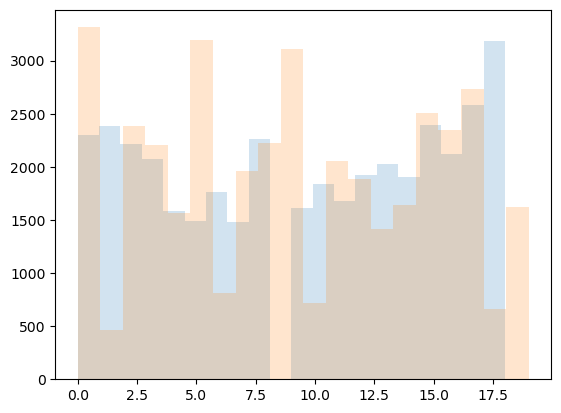

Accuracy: 0.066
0 2.9384718
1 2.793605
2 2.7088544
3 2.6624908
4 2.639899
5 2.588683
6 2.513702
7 2.4883862
8 2.4808788
9 2.467196
10 2.4449012
11 2.4348187
12 2.4317865
13 2.429776
14 2.4281394
15 2.4268222
16 2.4175005
17 2.3976505
18 2.3700657
19 2.3446283
20 2.336228
21 2.326362
22 2.3167176
23 2.3106139
24 2.303303
25 2.292364
26 2.282709
27 2.2742205
28 2.2711744
29 2.2681413
30 2.2666464
31 2.2656572
32 2.2649124
33 2.2641006
34 2.2635083
35 2.2630053
36 2.2625165
37 2.2621338
38 2.2617698
39 2.2615287
40 2.261261
41 2.2610242
42 2.260782
43 2.2605422
44 2.2603703
45 2.2602286
46 2.260033
47 2.2598987
48 2.2597399
49 2.259598
50 2.259475
51 2.259368
52 2.2592402
53 2.2591572
54 2.2590346
55 2.2589104
56 2.2587016
57 2.255979
58 2.2482185
59 2.2403584
60 2.2395244
61 2.2343671
62 2.2317948
63 2.2284732
64 2.227679
65 2.2264237
66 2.2258286
67 2.2251768
68 2.224236
69 2.2237332
70 2.223589
71 2.2231991
72 2.2228553
73 2.2226188
74 2.222261
75 2.2223005
76 2.2216613
77 2.2217476
78

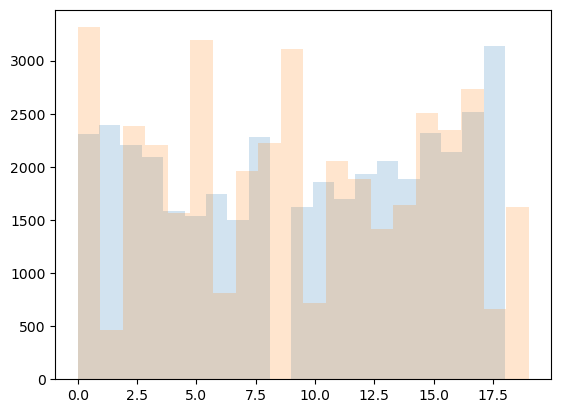

Accuracy: 0.067
0 2.9366636
1 2.7890801
2 2.7047427
3 2.6597457
4 2.6338885
5 2.578976
6 2.5154507
7 2.4873533
8 2.480845
9 2.477616
10 2.4702795
11 2.447014
12 2.4341311
13 2.4311233
14 2.428751
15 2.4229488
16 2.4069817
17 2.3927653
18 2.368657
19 2.3449943
20 2.3268843
21 2.3200247
22 2.3119879
23 2.3083827
24 2.3054655
25 2.2957544
26 2.2850409
27 2.277388
28 2.2717688
29 2.2681265
30 2.2669976
31 2.2653434
32 2.2645864
33 2.2639565
34 2.263221
35 2.262808
36 2.2623186
37 2.2619867
38 2.2616286
39 2.2612793
40 2.261079
41 2.2608283
42 2.2605574
43 2.2604134
44 2.260186
45 2.259915
46 2.2587507
47 2.2505546
48 2.2444558
49 2.2392538
50 2.2342277
51 2.2318738
52 2.2300756
53 2.228328
54 2.2270012
55 2.2258813
56 2.225428
57 2.2245052
58 2.2241807
59 2.2236109
60 2.2232795
61 2.2228
62 2.222724
63 2.2222424
64 2.222371
65 2.222055
66 2.2216651
67 2.2215075
68 2.2214181
69 2.2213035
70 2.22108
71 2.2208953
72 2.2208169
73 2.2207139
74 2.220563
75 2.2204573
76 2.220355
77 2.2202044
78 2

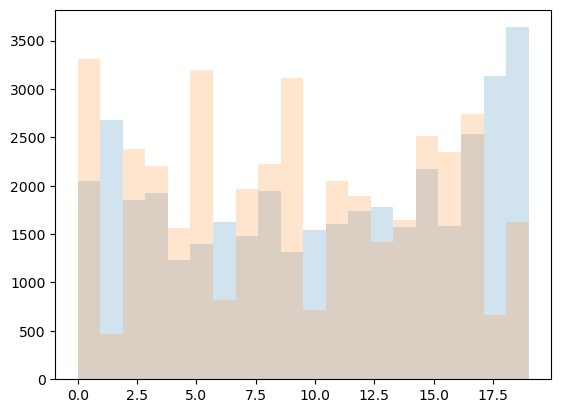

Accuracy: 0.064


In [476]:
model=MLP(161)

for cat in range(2,21):
    train_dl, test_dl = prepare_data(list(range(cat)),50)
    while True:
        ones_(model.hidden_last.weight)
        train_model(train_dl, model, 200)
        acc,cat_pred = evaluate_model(test_dl, model)
        print('Accuracy: %.3f' % acc)
        if cat_pred==cat: break
    

In [477]:
rn=str(random.choice(range(1000000)))
torch.save(model,"model_basic_"+rn+'.pickle')

25921
161
3220
20


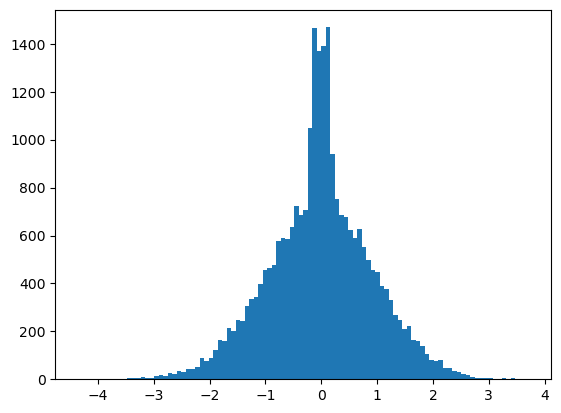

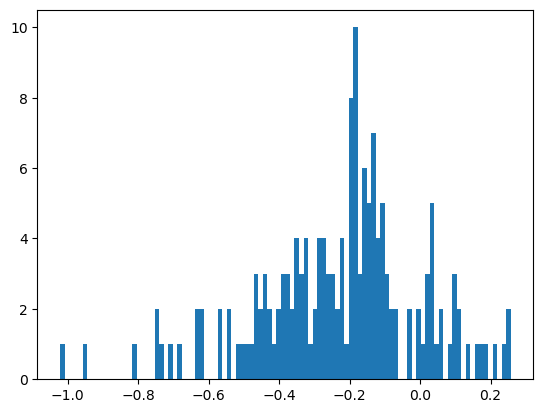

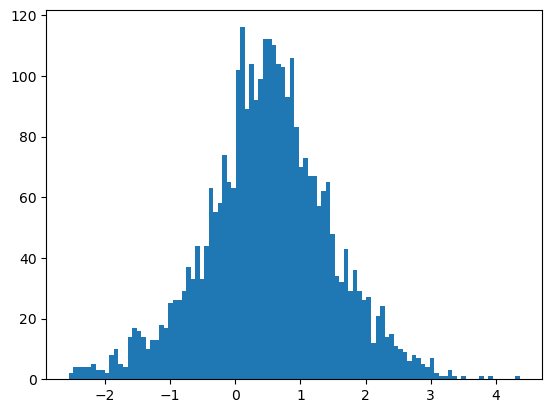

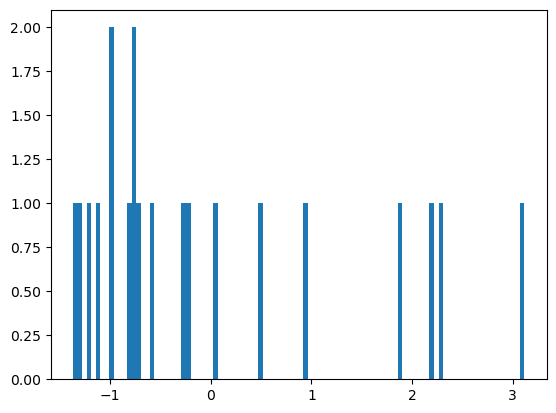

In [538]:
#print(numpy.mean(X_train,axis=0))
#print(list(model.parameters()))
for p in model.parameters():
    q=p.detach().numpy().flatten()
    print(q.size)
    plt.figure()
    plt.hist(q, bins=100)

In [510]:
for var_name in model.state_dict():
    print(var_name, "\t", model.state_dict()[var_name].shape)

hidden1.weight 	 torch.Size([161, 161])
hidden1.bias 	 torch.Size([161])
hidden_last.weight 	 torch.Size([20, 161])
hidden_last.bias 	 torch.Size([20])


Counts for minimal group: 1429
Counts for maximal group: 9982
train data: 200000, test data: 38829, categories: 20


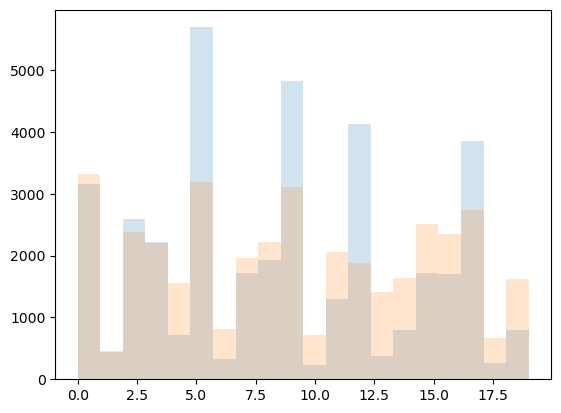

Accuracy: 0.134, Number of class: 20


In [540]:
train_dl, test_dl = prepare_data(list(range(20)),10000,10)
#model=torch.load("model_basic_933218.pickle")
#model=torch.load("model_basic_more_samples_472552.pickle")
model=torch.load("model_basic_all_samples_104804.pickle")
#train_model(train_dl, model,100)
acc,ncl = evaluate_model(test_dl, model)
print('Accuracy: %.3f, Number of class: %i' % (acc,ncl))

In [535]:
rn=str(random.choice(range(1000000)))
torch.save(model,"model_basic_all_samples_"+rn+'.pickle')

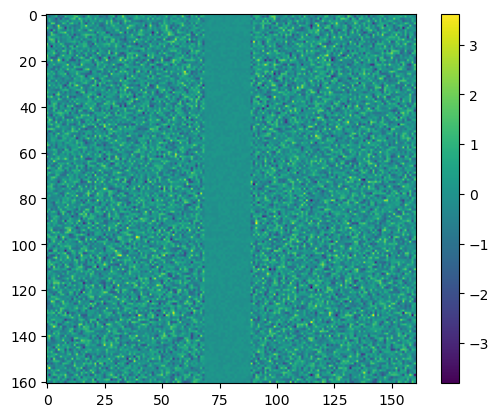

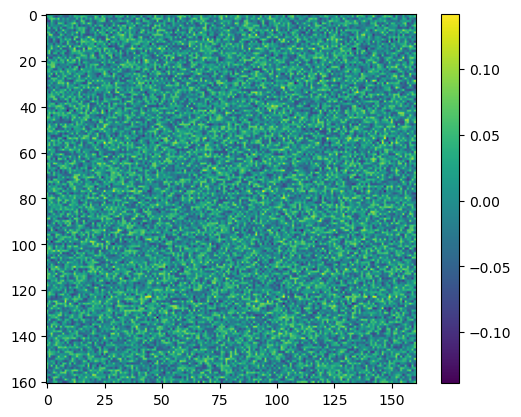

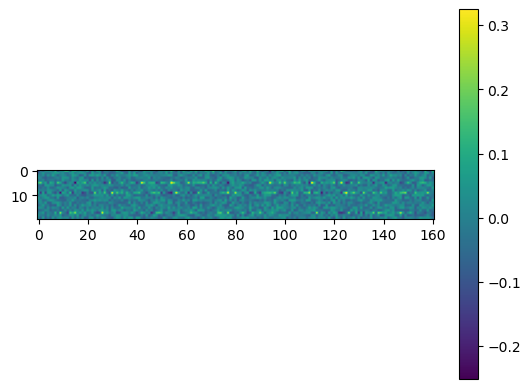

In [612]:
l1=model.hidden1.weight.detach().numpy()
plt.imshow(l1)
plt.colorbar()
l2=model.hidden2.weight.detach().numpy()
plt.figure()
plt.imshow(l2)
plt.colorbar()
l3=model.hidden_last.weight.detach().numpy()
plt.figure()
plt.imshow(l3)
plt.colorbar()


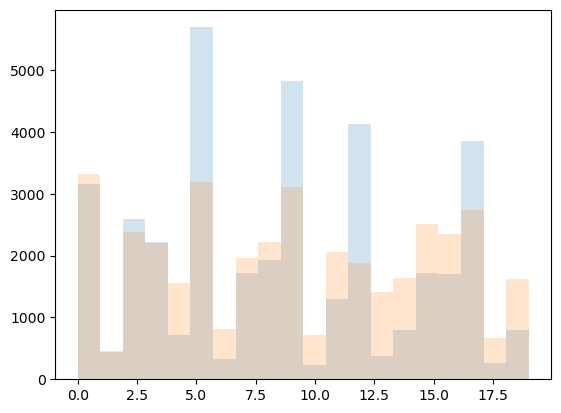

Accuracy: 0.134, Number of class: 20


In [557]:
#model_x=torch.load("model_basic_all_samples_104804.pickle")
#model.hidden1.weight=Parameter(model.hidden1.weight.repeat(2,1))
#model.hidden1.bias=Parameter(model.hidden1.bias.repeat(2))
#zeros_(model.hidden1.bias[161:])
#model.hidden_last.weight=Parameter(model.hidden_last.weight.repeat(1,2))
#zeros_(model.hidden_last.weight[:,161:])
#acc,ncl = evaluate_model(test_dl, model)
#print('Accuracy: %.3f, Number of class: %i' % (acc,ncl))


In [607]:
model_x=torch.load("model_basic_all_samples_104804.pickle")

class MLP(Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        N=161*1
        
        self.hidden1 = Linear(n_inputs, N)
        
        self.hidden1.weight=Parameter(model_x.hidden1.weight)
        self.hidden1.bias=Parameter(model_x.hidden1.bias)
        
        self.hidden1.weight.requires_grad = False
        self.hidden1.bias.requires_grad = False
        
        self.act1 = LeakyReLU()

        self.hidden2 = Linear(N, N)
        #eye_(self.hidden2.weight)
        #zeros_(self.hidden2.bias)
        self.act2 = LeakyReLU()
        
        self.hidden_last = Linear(N, 20)   
        #self.hidden_last.weight = Parameter(model_x.hidden_last.weight)
        #self.hidden_last.bias = Parameter(model_x.hidden_last.bias)
        self.act_last = Softmax(dim=1)

    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
        X = self.hidden2(X)
        X = self.act2(X)
        #last
        X = self.hidden_last(X)
        X = self.act_last(X)
        return X

0 2.718202
1 2.7186291
2 2.716681
3 2.7153986
4 2.714699
5 2.71428
6 2.7131696
7 2.7126956
8 2.7123132
9 2.7114074
10 2.7110145
11 2.7112849
12 2.7106586
13 2.7099285
14 2.7086987
15 2.7082496
16 2.707323
17 2.7061822
18 2.7055311
19 2.705019
20 2.7044516
21 2.703438
22 2.7033172
23 2.7023206
24 2.7014446
25 2.7011652
26 2.699884
27 2.6995776
28 2.698982
29 2.6983004
30 2.6979249
31 2.6970181
32 2.6965742
33 2.696408
34 2.6957123
35 2.6954334
36 2.694895
37 2.6944144
38 2.6939785
39 2.6934628
40 2.6930702
41 2.692801
42 2.6921406
43 2.6918185
44 2.6907961
45 2.6906
46 2.6902978
47 2.6898322
48 2.6896894
49 2.6895916
50 2.6894343
51 2.6888006
52 2.6886272
53 2.6883204
54 2.6882865
55 2.687666
56 2.687633
57 2.6870685
58 2.6869876
59 2.686565
60 2.6865034
61 2.6861572
62 2.6858084
63 2.6852973
64 2.6849658
65 2.6846683
66 2.6842585
67 2.6837604
68 2.6833336
69 2.683198
70 2.6831384
71 2.6831007
72 2.6829183
73 2.6825805
74 2.6823547
75 2.682138
76 2.6818202
77 2.6817486
78 2.6815443
79 2

605 2.5906515
606 2.5905762
607 2.590247
608 2.590175
609 2.5901008
610 2.5900507
611 2.5899134
612 2.590052
613 2.5897162
614 2.5897162
615 2.5894446
616 2.5894055
617 2.5893896
618 2.5893774
619 2.5893652
620 2.5893555
621 2.5891373
622 2.5891023
623 2.5890415
624 2.588729
625 2.5886583
626 2.5886254
627 2.5884705
628 2.5880358
629 2.5878022
630 2.5873296
631 2.5871046
632 2.5870032
633 2.5869763
634 2.586955
635 2.58684
636 2.5867584
637 2.586709
638 2.5867074
639 2.586554
640 2.5865183
641 2.5864408
642 2.586419
643 2.586367
644 2.586195
645 2.5862415
646 2.5857482
647 2.5857086
648 2.5855243
649 2.5854678
650 2.5854554
651 2.5852423
652 2.585106
653 2.58505
654 2.5849786
655 2.5849586
656 2.5849755
657 2.5847344
658 2.5847077
659 2.5846915
660 2.5847156
661 2.5846405
662 2.584345
663 2.584029
664 2.5840008
665 2.5837817
666 2.5836346
667 2.5835602
668 2.5834906
669 2.5834699
670 2.583455
671 2.5834448
672 2.5834332
673 2.5835035
674 2.5838711
675 2.5832436
676 2.5831985
677 2.5831

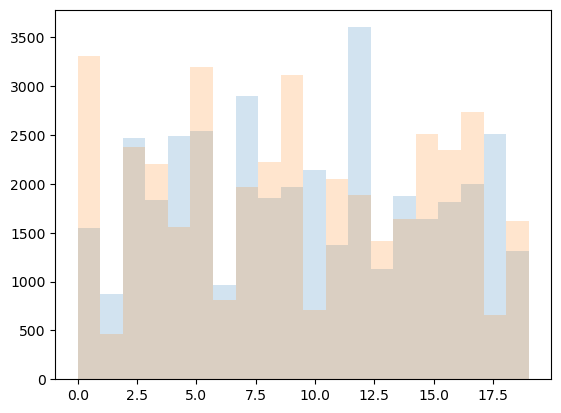

Accuracy: 0.079, Number of class: 20


In [628]:
#model=MLP(161)
#train_dl, test_dl = prepare_data(list(range(20)),200,batch_size=10)
train_model(train_dl, model,1000, lr=0.01)
acc,ncl = evaluate_model(test_dl, model)
print('Accuracy: %.3f, Number of class: %i' % (acc,ncl))